In [1]:
%matplotlib inline
from pathlib import Path

import numpy as np
import scipy.signal as sps

from spectrometer import FID1D, plot, process

Did not find any configuration file. Using defaults.


In [2]:
# Load raw *.fid data
file = Path("../data/20230822-091753-Water-1H-single_90_degree_pulse,length=9us,delay=25us,record_length=10000,sample_rate=320000,probe=andrew.fid")
fid = FID1D.from_file(file)

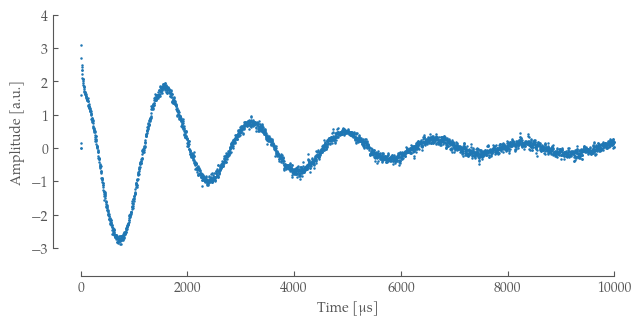

In [3]:
# Plot raw data
cm = 1 / 2.54
fig, axes = plot.subplots(
    figsize=(16.0 * cm, 8.0 * cm),  # Wide Layout: ~16cm, Margin Layout: 10.7cm
)
axes.plot(
    fid.us_scale,
    fid.data.real,
    linestyle="",
    marker="o",
    markersize=0.8,
)
axes.set_ylabel("Amplitude [a.u.]")
axes.set_xlabel("Time [μs]")

plot.format_axes(axes)

fig.savefig("fid_raw.pdf")

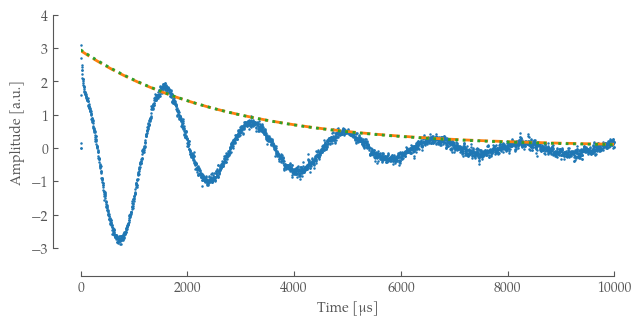

In [4]:
# Try fitting the envelope
try:
    # Plot raw data
    cm = 1 / 2.54
    fig, axes = plot.subplots(
        figsize=(16.0 * cm, 8.0 * cm),  # Wide Layout: ~16cm, Margin Layout: 10.7cm
    )
    axes.plot(
        fid.us_scale,
        fid.data.real,
        linestyle="",
        marker="o",
        markersize=0.8,
    )
    axes.set_ylabel("Amplitude [a.u.]")
    axes.set_xlabel("Time [μs]")

    plot.format_axes(axes)

    envelope = np.abs(sps.hilbert(fid.data.real))
    fit_lorentz = process.fit_exp_decay(fid.us_scale, envelope)
    hz_scale_fine = np.linspace(fid.us_scale[0], fid.us_scale[-1], len(fid.us_scale) * 10)
    axes.plot(
        hz_scale_fine,
        fit_lorentz["function"](hz_scale_fine),
        linestyle="--",
        linewidth=2,
    )

    # Try fitting the absolute directly
    fit_abs = process.fit_exp_decay(fid.us_scale, np.abs(fid.data))
    axes.plot(
        hz_scale_fine,
        fit_abs["function"](hz_scale_fine),
        linestyle=":",
        linewidth=2,
    )
except RuntimeError:
    pass

fig.savefig("fid_envelope_fit.pdf")

Amplitude: 3.170655731283511
Frequency: 9.377632751673733e-05
Phase: 2.0224788873192594
Offset: -0.02066308636970356


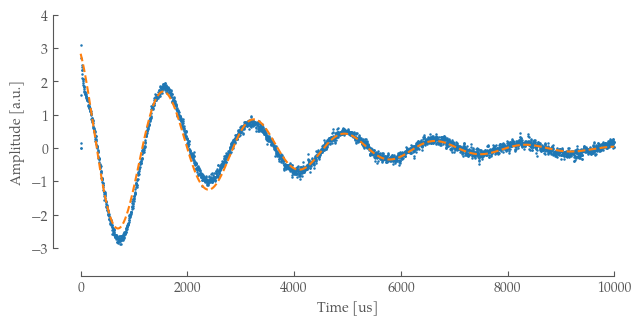

In [5]:
# Try to plot simple least squares fit for a decaying sinusoid
fit_decaying_sinusoid = process.fit_decaying_sinusoid(fid.us_scale, fid.data.real)
us_scale_fine = np.linspace(fid.us_scale[0], fid.us_scale[-1], len(fid.us_scale) * 10)

print(f"Amplitude: {fit_decaying_sinusoid['amplitude']}")
print(f"Frequency: {fit_decaying_sinusoid['frequency'] / (2*np.pi)}")
print(f"Phase: {fit_decaying_sinusoid['phase']}")
print(f"Offset: {fit_decaying_sinusoid['offset']}")

# Plot manually
cm = 1 / 2.54
fig, axes = plot.subplots(figsize=(16*cm, 8*cm))
axes.set_ylabel("Amplitude [a.u.]")
axes.set_xlabel("Time [us]")

# Plot raw values again
axes.plot(
    fid.us_scale,
    fid.data.real,
    linestyle="",
    marker="o",
    markersize=0.8,
)

# Plot fit
axes.plot(
    us_scale_fine,
    fit_decaying_sinusoid["function"](us_scale_fine),
    linestyle="--",
)

plot.format_axes(axes)
fig.savefig("fid_sine_fit.pdf")

Phase Shift: 37.15743750000004


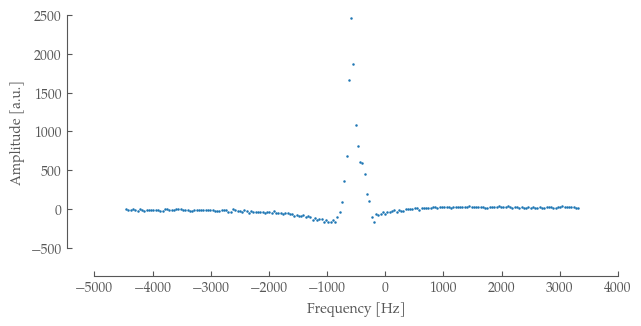

In [6]:
# Fourier Transform
hz_scale, fft_vals,p0 = fid.simple_fft()
peak = np.argmax(np.abs(fft_vals))
peak_hz_scale = hz_scale[peak-100:peak+100]
peak_fft_vals = fft_vals[peak-100:peak+100]
print(f"Phase Shift: {p0}")

# Plot Fourier Transform
cm = 1 / 2.54
fig, axes = plot.subplots(
    figsize=(16.0 * cm, 8.0 * cm),  # Wide Layout: ~16cm, Margin Layout: 10.7cm
)
axes.plot(
    peak_hz_scale,
    peak_fft_vals.real,
    linestyle="",
    marker="o",
    markersize=0.8,
)
axes.set_ylabel("Amplitude [a.u.]")
axes.set_xlabel("Frequency [Hz]")

plot.format_axes(axes)

fig.savefig("fft_raw.pdf")

Amplitude: 2505.992381398561
Gamma: 58.82949700492848 Hz
Full Width at Half Maximum: 117.65899400985695 Hz
T2* is thus: 2.7053595763118974 ms
Position: -576.7271113299021 Hz


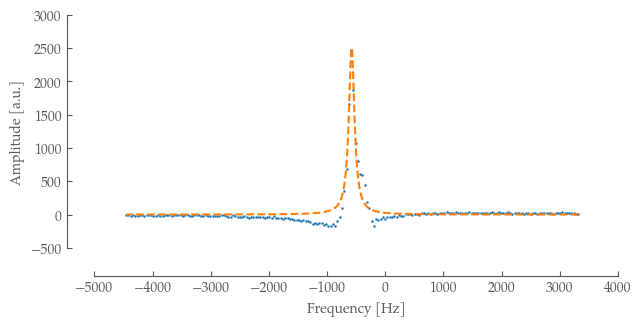

In [7]:
# Try to plot simple least squares fit for a lorentzian peak
fit_lorentz = process.fit_lorentz(peak_hz_scale, peak_fft_vals.real)
hz_scale_fine = np.linspace(peak_hz_scale[0], peak_hz_scale[-1], len(fid.us_scale) * 10)

# Plot Raw
cm = 1 / 2.54
fig, axes = plot.subplots(
    figsize=(16.0 * cm, 8.0 * cm),  # Wide Layout: ~16cm, Margin Layout: 10.7cm
)
axes.plot(
    peak_hz_scale,
    peak_fft_vals.real,
    linestyle="",
    marker="o",
    markersize=0.8,
)
axes.set_ylabel("Amplitude [a.u.]")
axes.set_xlabel("Frequency [Hz]")

plot.format_axes(axes)

# Plot fit
axes.plot(
    hz_scale_fine,
    fit_lorentz["function"](hz_scale_fine),
    linestyle="--",
)
print(f"Amplitude: {fit_lorentz['amplitude']}")
print(f"Gamma: {fit_lorentz['gamma']} Hz")
print(f"Full Width at Half Maximum: {fit_lorentz['gamma'] * 2} Hz")
print(f"T2* is thus: {1000/(np.pi * fit_lorentz['gamma']*2)} ms")
print(f"Position: {fit_lorentz['position']} Hz")


fig.savefig("fft_fit.pdf")